# Copula Based Outlier Detector with MaxAbsScaler

This code template is for Anomaly detection/outlier analysis using the COPOD Algorithm implemented using pyod library along with feature scaling using MaxAbsScaler.

### Required Packages

In [ ]:
!pip install plotly
!pip install pyod

In [ ]:
import time
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from pyod.models.copod import COPOD
from sklearn.preprocessing import LabelEncoder,MaxAbsScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [3]:
file_path= ''

List of features which are  required for model training .

In [4]:
features=[]

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [5]:
df=pd.read_csv(file_path)
df.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [6]:
X=df[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [7]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature set.


In [8]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])  
X=EncodeX(X)
X.head()

Survived  Pclass   Age  SibSp  Parch
0         0       3  22.0      1      0
1         1       1  38.0      1      0
2         1       3  26.0      0      0
3         1       1  35.0      1      0
4         0       3  35.0      0      0

### Rescaling technique
#### MaxAbs Scaler

MaxAbsScaler This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1.0. It does not shift/center the data, and thus does not destroy any sparsity.

This scaler can also be applied to sparse CSR or CSC matrices.

In [9]:
X_Scaled=MaxAbsScaler().fit_transform(X)
X_Scaled=pd.DataFrame(data = X_Scaled,columns = X.columns)
X_Scaled.head()

Survived    Pclass     Age  SibSp  Parch
0       0.0  1.000000  0.2750  0.125    0.0
1       1.0  0.333333  0.4750  0.125    0.0
2       1.0  1.000000  0.3250  0.000    0.0
3       1.0  0.333333  0.4375  0.125    0.0
4       0.0  1.000000  0.4375  0.000    0.0

### Data Splitting

The train-test split is a procedure for evaluating the performance of an algorithm. The procedure involves taking a dataset and dividing it into two subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [10]:
x_train,x_test=train_test_split(X_Scaled,test_size=0.2,random_state=123)

### Model
Used pyod.models.copod.COPOD

COPOD class for Copula Based Outlier Detector. COPOD is a parameter-free, highly interpretable outlier detection algorithm based on empirical copula models. 
#### Tuning parameters

**contamination** – The amount of contamination of the data set, i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function. 

**n_jobs** – The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.

Read more at [pyod.readthedocs.io](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.copod)

In [11]:
model = COPOD(contamination=0.001,n_jobs=-1)
model.fit(x_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.7s finished


COPOD(contamination=0.001, n_jobs=-1)

### Anomaly Prediction

In [12]:
result=x_test.copy(deep=True)
result['Anomaly']=model.predict(x_test)
result.head()

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Survived    Pclass       Age  SibSp     Parch  Anomaly
172       1.0  1.000000  0.012500  0.125  0.166667        0
524       0.0  1.000000  0.371239  0.000  0.000000        0
452       0.0  0.333333  0.375000  0.000  0.000000        0
170       0.0  0.333333  0.762500  0.000  0.000000        0
620       0.0  1.000000  0.337500  0.125  0.000000        0

### Anomaly Visualization

#### Bar Plot

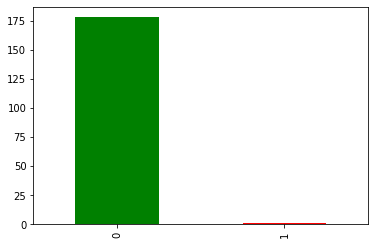

In [13]:
result['Anomaly'].value_counts().plot(kind='bar',color=['green','red'])

#### Pie Chart

In [14]:
fig = px.pie(result['Anomaly'],names=result['Anomaly'], title='Anomaly rate',)
fig.show()

#### Anomalies

In this part we will perform Dimensionality Reduction technique to visualize data. This can be performed using technique such as PCA or TSNE algorithms.

In [15]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(result.drop('Anomaly',axis=1))

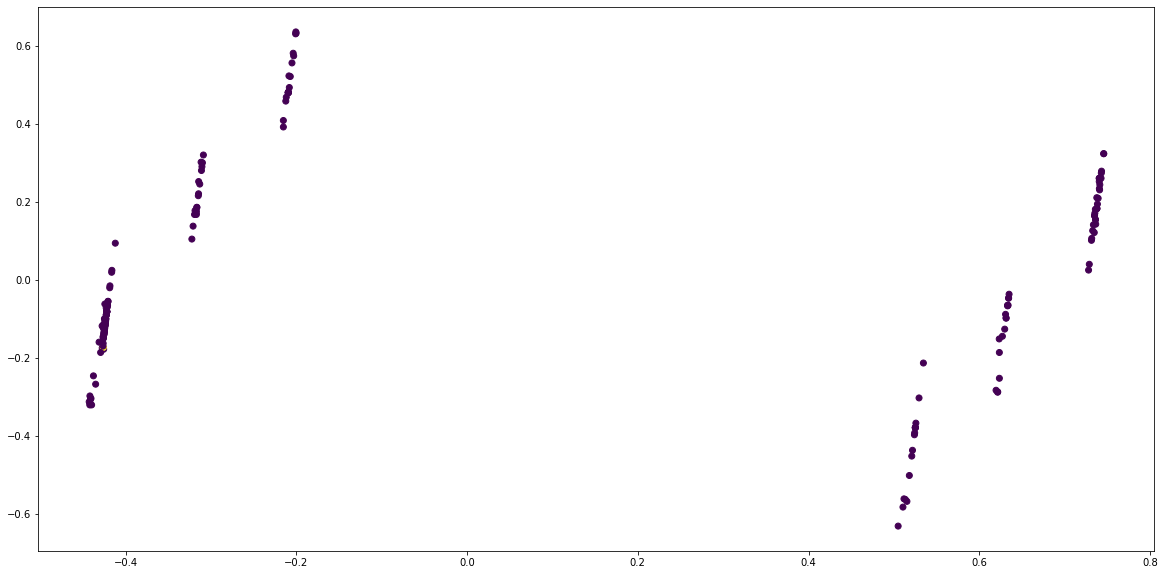

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(x=pca_results[:,0],y=pca_results[:,1],c=result.iloc[:,result.columns.get_loc('Anomaly')])
plt.show()

#### Creator: Arpit Somani , Github: [Profile](https://github.com/arpitsomani8)
